# Whale Portfolio Analysis

## Preparing the Data

In [1]:
# Import dependancies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

%matplotlib inline

In [2]:
# Read CSV files
whale_file = Path("Resources/whale_returns.csv")
algo_file = Path("Resources/algo_returns.csv")
sptsx_file = Path("Resources/sp_tsx_history.csv")

whale_df = pd.read_csv(whale_file, index_col="Date", parse_dates=True, infer_datetime_format=True)
whale_df.sort_index(inplace=True)
algo_df = pd.read_csv(algo_file, index_col="Date", parse_dates=True, infer_datetime_format=True)
algo_df.sort_index(inplace=True)
sptsx_df = pd.read_csv(sptsx_file, index_col="Date", parse_dates=True, infer_datetime_format=True)
sptsx_df.sort_index(inplace=True)

### Count and remove nulls

In [3]:
whale_df.isnull().sum()

SOROS FUND MANAGEMENT LLC      1
PAULSON & CO.INC.              1
TIGER GLOBAL MANAGEMENT LLC    1
BERKSHIRE HATHAWAY INC         1
dtype: int64

In [4]:
whale_df = whale_df.dropna().copy()
whale_df.isnull().sum()

SOROS FUND MANAGEMENT LLC      0
PAULSON & CO.INC.              0
TIGER GLOBAL MANAGEMENT LLC    0
BERKSHIRE HATHAWAY INC         0
dtype: int64

In [5]:
algo_df.isnull().sum()

Algo 1    0
Algo 2    6
dtype: int64

In [6]:
algo_df = algo_df.dropna().copy()
algo_df.isnull().sum()

Algo 1    0
Algo 2    0
dtype: int64

In [7]:
sptsx_df.isnull().sum()

Close    0
dtype: int64

In [8]:
# Check and remove any duplicated dates
print(whale_df.index.duplicated().sum())
print(algo_df.index.duplicated().sum())
print(sptsx_df.index.duplicated().sum())

0
0
0


In [9]:
# Remove any non numeric characters and convert the data type to float
sptsx_df["Close"] = sptsx_df["Close"].str.replace("$", "")
sptsx_df["Close"] = sptsx_df["Close"].str.replace(",", "")
sptsx_df = sptsx_df.astype("float")

C:\Users\lendl\anaconda3\envs\dev\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  


In [10]:
# Convert S&P TSX 60 from closing prices to daily returns
sptsx_df = sptsx_df.pct_change()
sptsx_df = sptsx_df.dropna()
sptsx_df.head()

,Close
Date,
2012-10-02,0.001701
2012-10-03,-0.002563
2012-10-04,0.007137
2012-10-05,-0.002305
2012-10-09,-0.011709


In [11]:
# Rename Close
sptsx_df = sptsx_df.rename({"Close":"S&P TSX 60"}, axis=1)

In [12]:
# Concat whale returns, algorithmic returns, and S&P TSX 60
daily_returns = pd.concat(
    [
        whale_df, algo_df, sptsx_df
    ], axis=1, join="inner"
)
daily_returns.sort_index(inplace=True)
daily_returns.head()

,SOROS FUND MANAGEMENT LLC,PAULSON & CO.INC.,TIGER GLOBAL MANAGEMENT LLC,BERKSHIRE HATHAWAY INC,Algo 1,Algo 2,S&P TSX 60
Date,,,,,,,
2015-03-03,-0.001266,-0.004981,-0.000496,-0.006569,-0.001942,-0.000949,-0.008530
2015-03-04,0.002230,0.003241,-0.002534,0.004213,-0.008589,0.002416,-0.003371
2015-03-05,0.004016,0.004076,0.002355,0.006726,-0.000955,0.004323,0.001344
2015-03-06,-0.007905,-0.003574,-0.008481,-0.013098,-0.004957,-0.011460,-0.009972
2015-03-09,0.000582,0.004225,0.005843,-0.001652,-0.005447,0.001303,-0.006555


## Conduct Quantitative Analysis

#### Performance Analysis

<AxesSubplot:title={'center':'Daily Returns'}, xlabel='Date'>

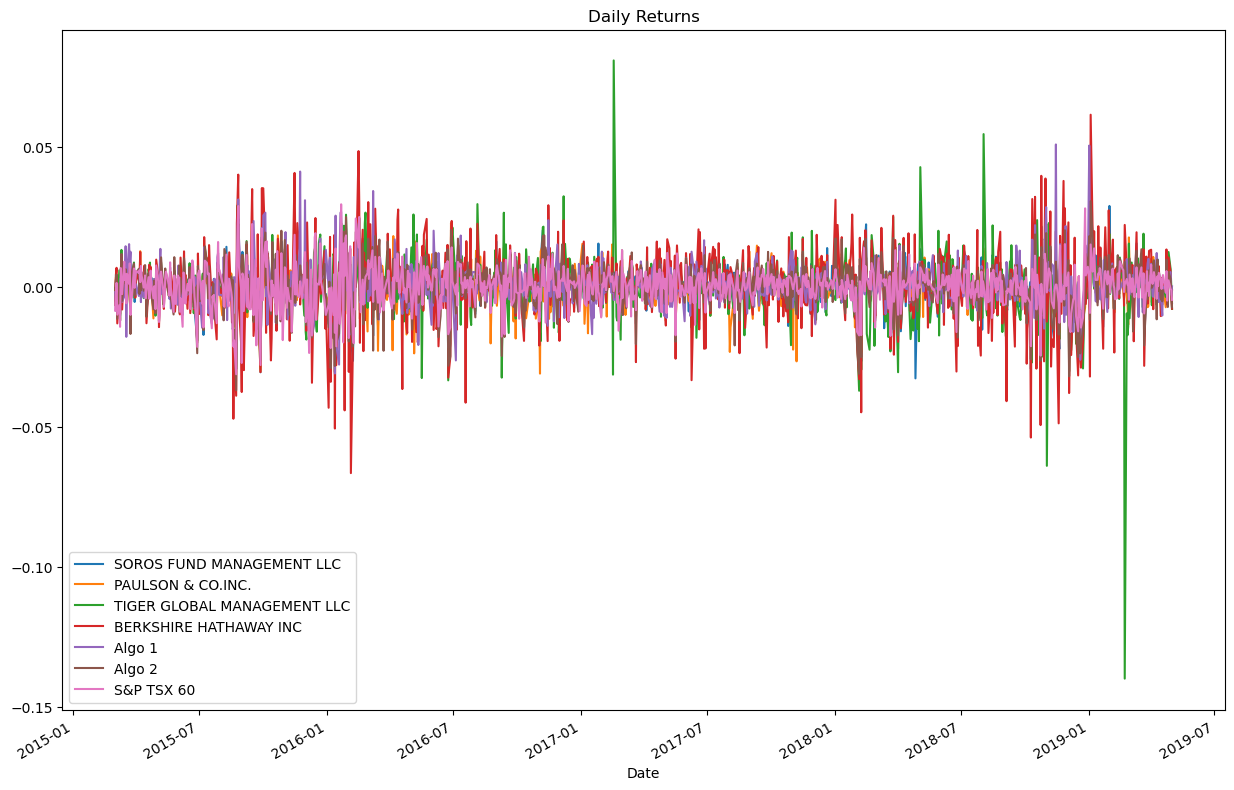

In [13]:
# Plot daily returns
daily_returns.plot(figsize=(15,10),legend=True, title="Daily Returns")

<AxesSubplot:title={'center':'Cumulative Returns'}, xlabel='Date'>

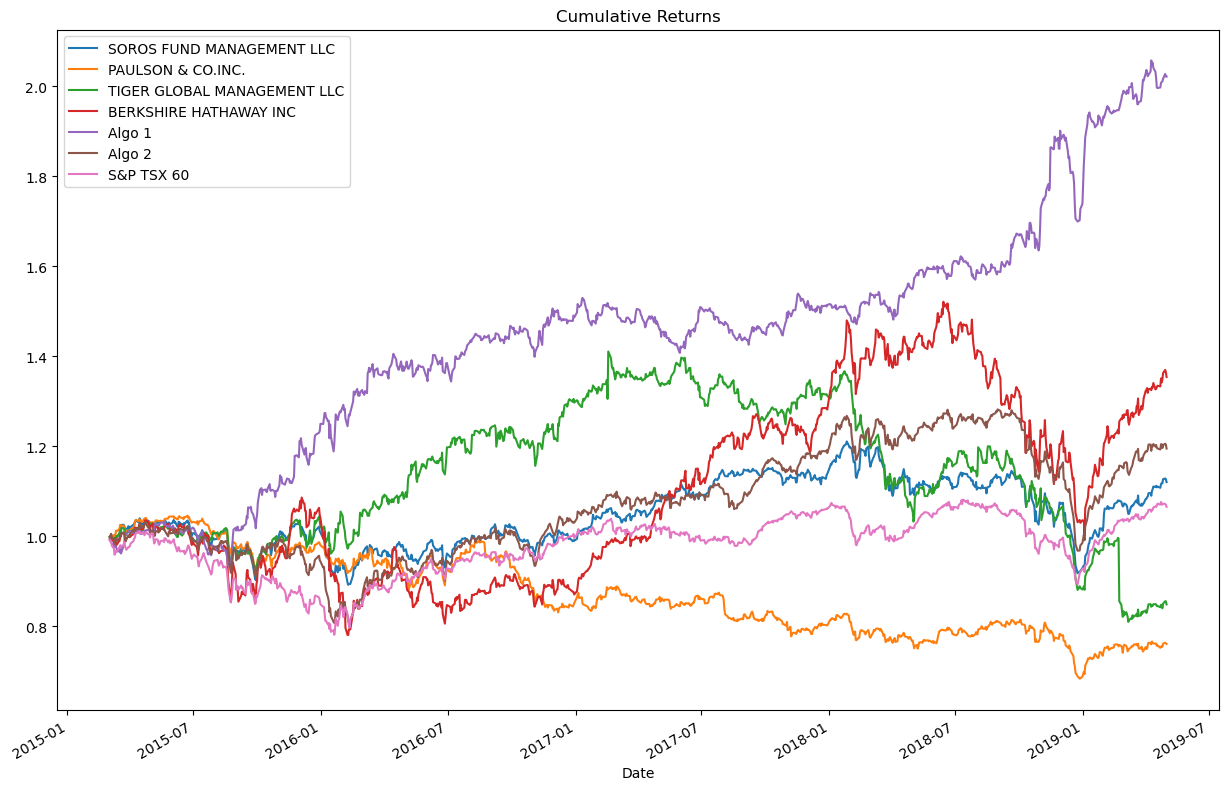

In [14]:
# Calculate cumulative returns for all portfolios
cumulative_returns = (1 + daily_returns).cumprod()
cumulative_returns.plot(figsize=(15,10), title="Cumulative Returns")

#### Risk Analysis

(array([1, 2, 3, 4, 5, 6, 7]),
 [Text(1, 0, 'SOROS FUND MANAGEMENT LLC'),
  Text(2, 0, 'PAULSON & CO.INC. '),
  Text(3, 0, 'TIGER GLOBAL MANAGEMENT LLC'),
  Text(4, 0, 'BERKSHIRE HATHAWAY INC'),
  Text(5, 0, 'Algo 1'),
  Text(6, 0, 'Algo 2'),
  Text(7, 0, 'S&P TSX 60')])

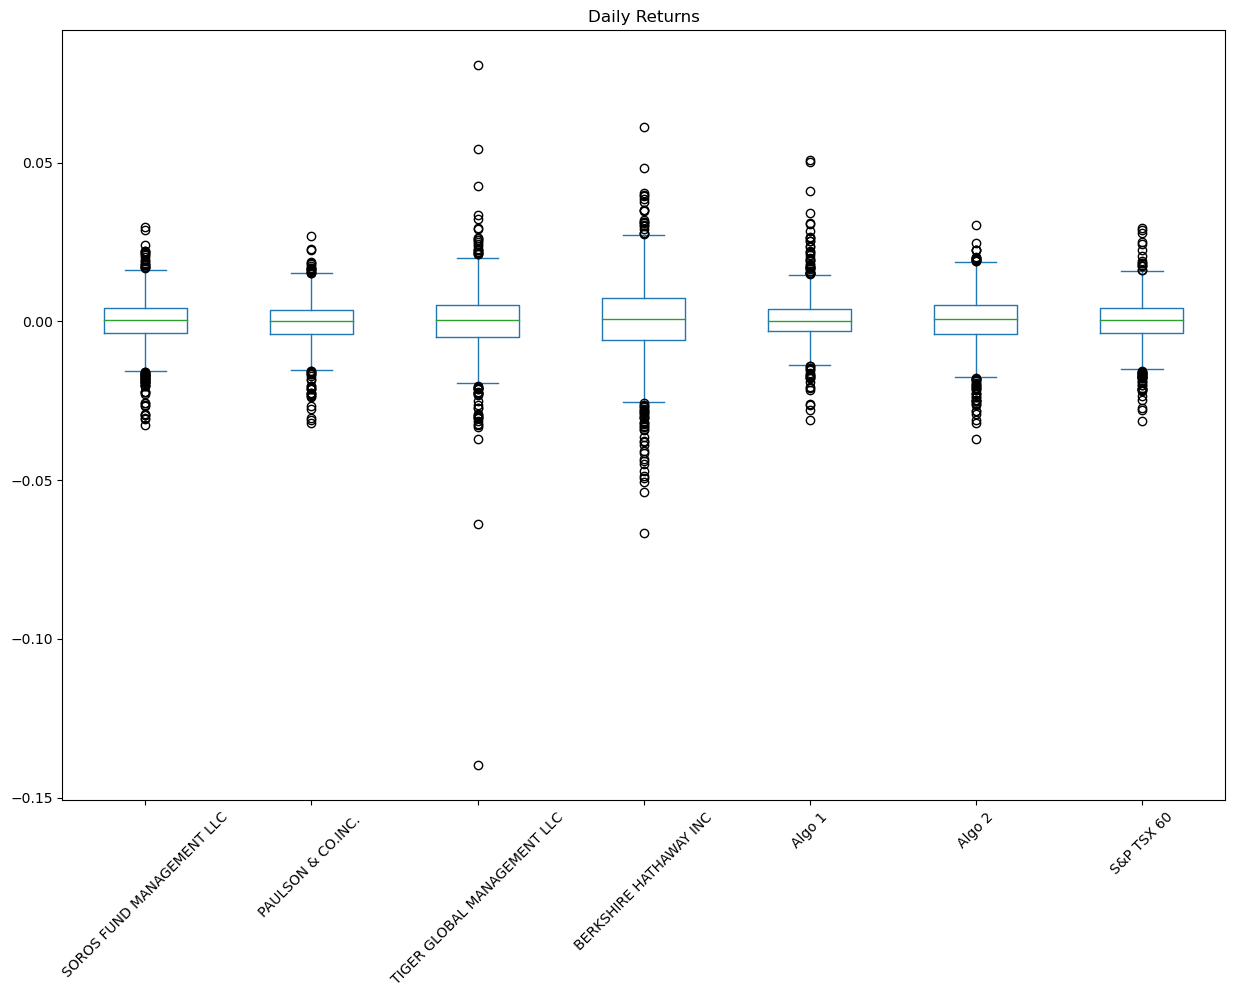

In [15]:
daily_returns.plot.box(figsize=(15,10), title="Daily Returns")
plt.xticks(rotation=45)

In [16]:
# Calculate the Standard Deviation of each portfolio
portfolio_std = daily_returns.std()
portfolio_std

SOROS FUND MANAGEMENT LLC      0.007828
PAULSON & CO.INC.              0.006982
TIGER GLOBAL MANAGEMENT LLC    0.010883
BERKSHIRE HATHAWAY INC         0.012826
Algo 1                         0.007589
Algo 2                         0.008326
S&P TSX 60                     0.007034
dtype: float64

In [17]:
# Determine which portfolios are riskier than the S&P TSXX 60
portfolio_std > portfolio_std["S&P TSX 60"]

SOROS FUND MANAGEMENT LLC       True
PAULSON & CO.INC.              False
TIGER GLOBAL MANAGEMENT LLC     True
BERKSHIRE HATHAWAY INC          True
Algo 1                          True
Algo 2                          True
S&P TSX 60                     False
dtype: bool

In [18]:
# Calculate the annualized standard deviation
annual_std = portfolio_std * np.sqrt(252)
annual_std

SOROS FUND MANAGEMENT LLC      0.124259
PAULSON & CO.INC.              0.110841
TIGER GLOBAL MANAGEMENT LLC    0.172759
BERKSHIRE HATHAWAY INC         0.203599
Algo 1                         0.120470
Algo 2                         0.132177
S&P TSX 60                     0.111664
dtype: float64

In [19]:
annual_std > annual_std["S&P TSX 60"]

SOROS FUND MANAGEMENT LLC       True
PAULSON & CO.INC.              False
TIGER GLOBAL MANAGEMENT LLC     True
BERKSHIRE HATHAWAY INC          True
Algo 1                          True
Algo 2                          True
S&P TSX 60                     False
dtype: bool

#### Rolling Statistics

<AxesSubplot:title={'center':'21SMA Standard Deviation'}, xlabel='Date'>

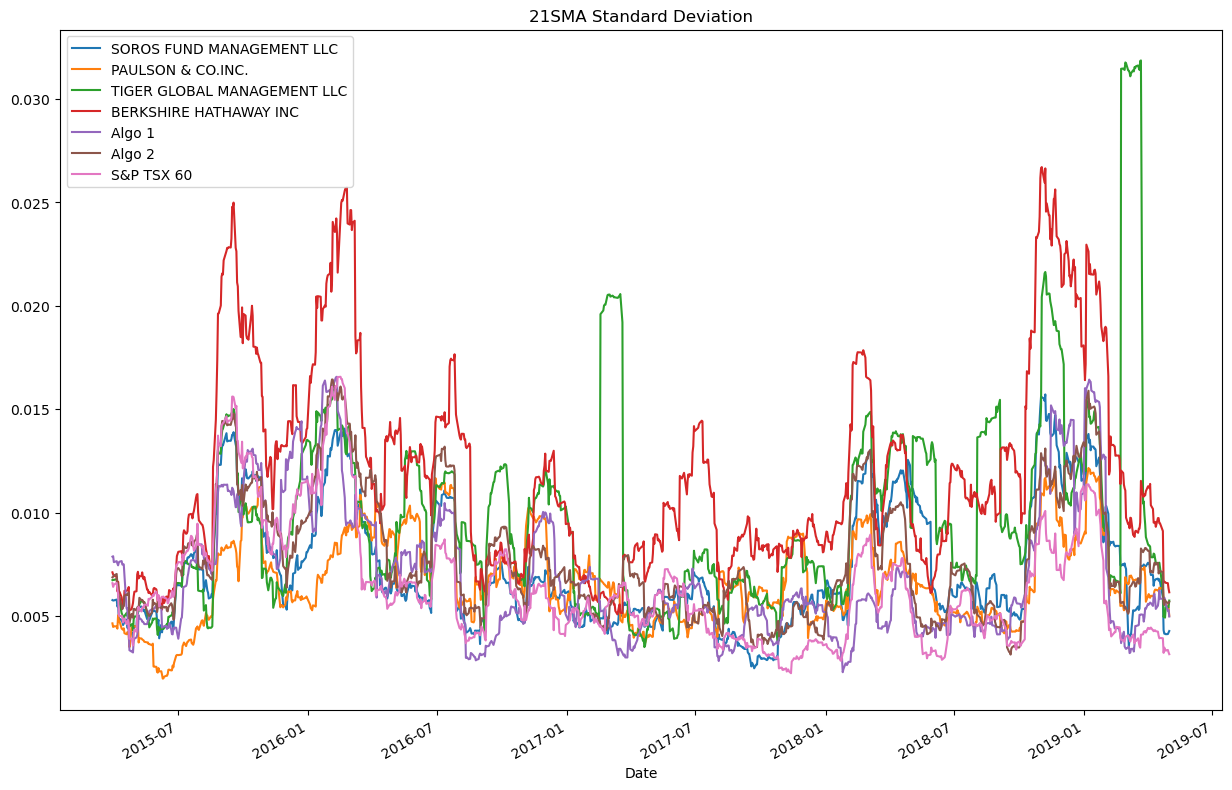

In [20]:
# Calculate the rolling standard deviation for all portfolios for a 21-days window
rolling_std = daily_returns.rolling(window=21).std()
rolling_std.plot(figsize=(15,10), title="21SMA Standard Deviation")

#### Correlation

In [21]:
# Calculate the correlation between each stock to the S&P TSX 60
corr = daily_returns.corr()
corr

,SOROS FUND MANAGEMENT LLC,PAULSON & CO.INC.,TIGER GLOBAL MANAGEMENT LLC,BERKSHIRE HATHAWAY INC,Algo 1,Algo 2,S&P TSX 60
SOROS FUND MANAGEMENT LLC,1.000000,0.697076,0.560964,0.750181,0.313795,0.826667,0.673930
PAULSON & CO.INC.,0.697076,1.000000,0.433034,0.540033,0.266363,0.674015,0.486511
TIGER GLOBAL MANAGEMENT LLC,0.560964,0.433034,1.000000,0.423524,0.161236,0.506689,0.440583
BERKSHIRE HATHAWAY INC,0.750181,0.540033,0.423524,1.000000,0.289378,0.684609,0.557250
Algo 1,0.313795,0.266363,0.161236,0.289378,1.000000,0.285455,0.310276
Algo 2,0.826667,0.674015,0.506689,0.684609,0.285455,1.000000,0.737370
S&P TSX 60,0.673930,0.486511,0.440583,0.557250,0.310276,0.737370,1.000000


<AxesSubplot:>

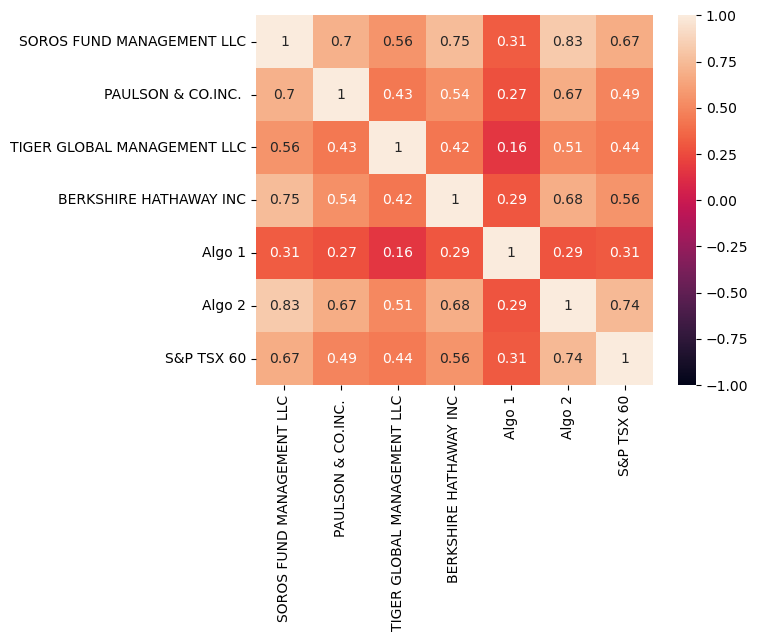

In [22]:
# Plot a heatmap
sns.heatmap(corr, vmin=-1, vmax=1, annot=True)

#### Beta Analysis

<AxesSubplot:title={'center':'Algo 1 Beta'}, xlabel='Date'>

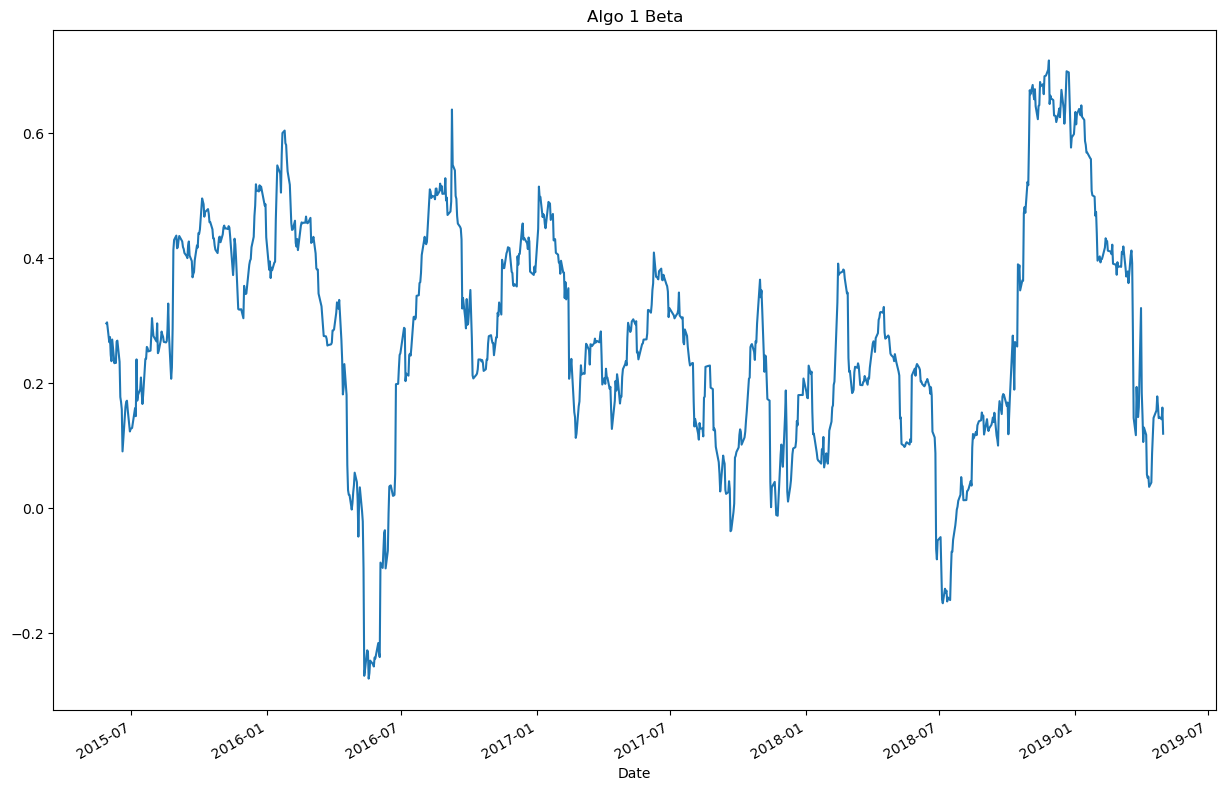

In [23]:
# Calculate the rolling covariance of Algo 1 to the Index
algo_rolling_cov = daily_returns["Algo 1"].rolling(window=60).cov(daily_returns["S&P TSX 60"])

# Calculate the rolling variance of the S&P TSX 60
rolling_variance = daily_returns["S&P TSX 60"].rolling(window=60).var()

# Calculate the rolling beta of Algo 1
algo_rolling_beta = algo_rolling_cov/rolling_variance

# Plot the beta
algo_rolling_beta.plot(figsize=(15,10), title="Algo 1 Beta")

#### Rolling Statistics of Standard Deviation: Weighted Average

<AxesSubplot:title={'center':'Exponential Weighted Average - Standard Deviation'}, xlabel='Date'>

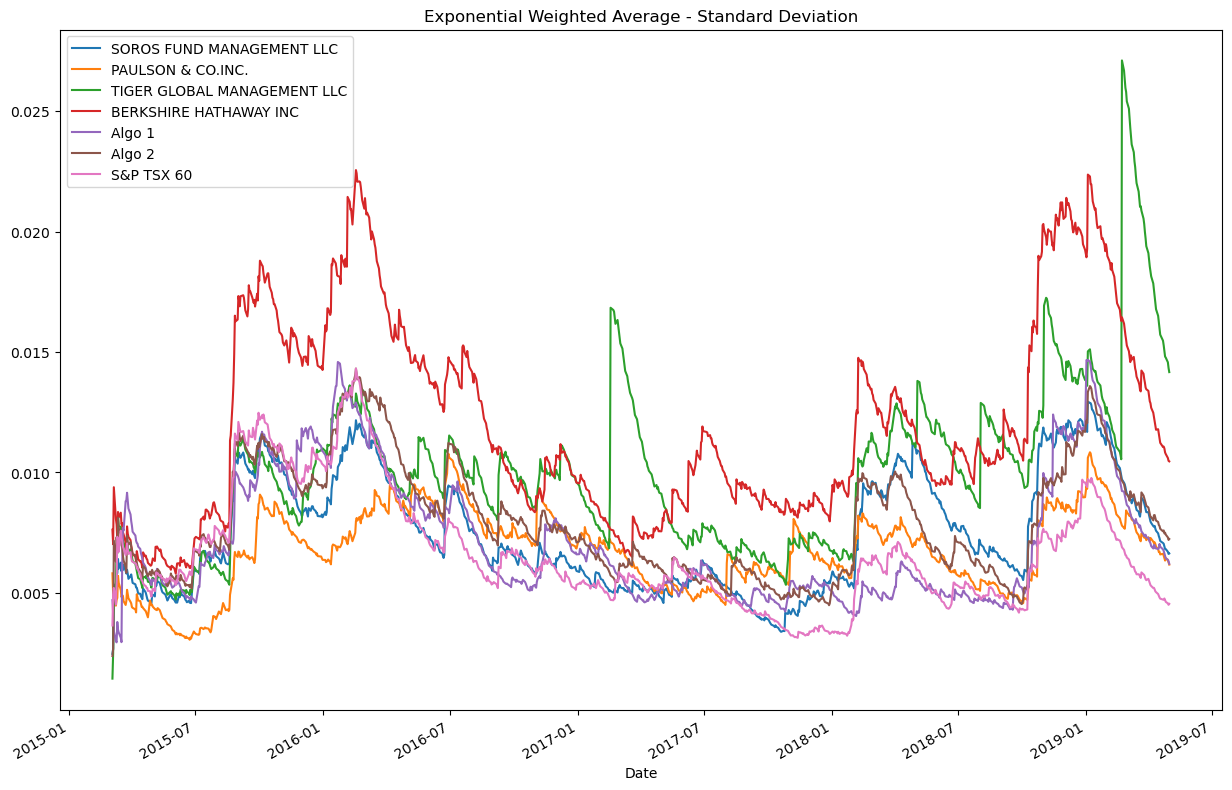

In [24]:
# Calculate 21-day exponential weighted average
daily_returns.ewm(halflife=21).std().plot(figsize=(15,10), title="Exponential Weighted Average - Standard Deviation")

#### Sharpe Ratios

<AxesSubplot:title={'center':'Sharpe Ratios'}>

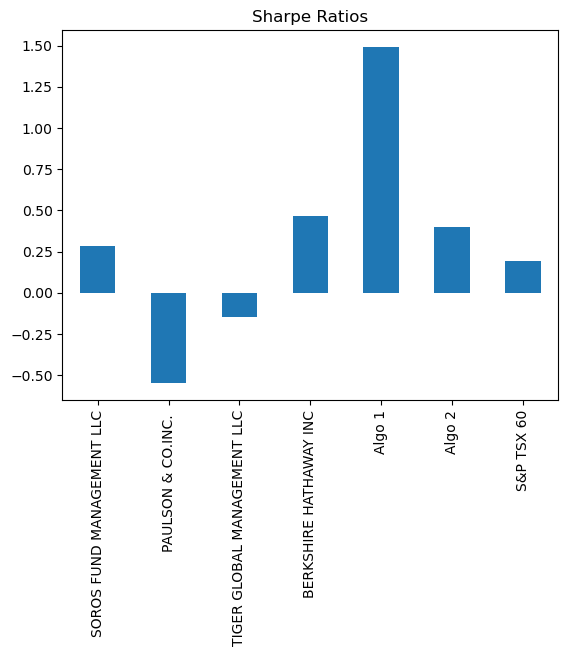

In [25]:
# Calculate and visualize the Sharpe ratios
sharpe_ratios = (daily_returns.mean()*252)/(daily_returns.std()*np.sqrt(252))
sharpe_ratios.plot.bar(title="Sharpe Ratios")

In [26]:
# Determin that the algorithmic strategies outperform both the market and whales portfolios
sharpe_ratios["Algo 1"] > sharpe_ratios

SOROS FUND MANAGEMENT LLC       True
PAULSON & CO.INC.               True
TIGER GLOBAL MANAGEMENT LLC     True
BERKSHIRE HATHAWAY INC          True
Algo 1                         False
Algo 2                          True
S&P TSX 60                      True
dtype: bool

In [27]:
# Determin that the algorithmic strategies outperform both the market and whales portfolios
sharpe_ratios["Algo 2"] > sharpe_ratios

SOROS FUND MANAGEMENT LLC       True
PAULSON & CO.INC.               True
TIGER GLOBAL MANAGEMENT LLC     True
BERKSHIRE HATHAWAY INC         False
Algo 1                         False
Algo 2                         False
S&P TSX 60                      True
dtype: bool

# Custom Portfolio

Choose 5 random stocks for a custom portfolio to see if the portfolio performs as well as the Algorithmic portfolios.

In [28]:
# Read in the 5 stock csv files
amzn_file = Path("Resources/amzn.csv")
nvda_file = Path("Resources/nvda.csv")
td_file = Path("Resources/td.csv")
xom_file = Path("Resources/xom.csv")
nflx_file = Path("Resources/nflx.csv")

amzn_df = pd.read_csv(amzn_file, index_col="Date", parse_dates=True, infer_datetime_format=True)
amzn_df = amzn_df.sort_index()
nvda_df = pd.read_csv(nvda_file, index_col="Date", parse_dates=True, infer_datetime_format=True)
nvda_df = nvda_df.sort_index()
td_df = pd.read_csv(td_file, index_col="Date", parse_dates=True, infer_datetime_format=True)
td_df = td_df.sort_index()
xom_df = pd.read_csv(xom_file, index_col="Date", parse_dates=True, infer_datetime_format=True)
xom_df = xom_df.sort_index()
nflx_df = pd.read_csv(nflx_file, index_col="Date", parse_dates=True, infer_datetime_format=True)
nflx_df = nflx_df.sort_index()

In [29]:
# Rename the close price column to the ticker name
amzn_df.columns=["AMZN"]
nvda_df.columns=["NVDA"]
td_df.columns=["TD"]
xom_df.columns=["XOM"]
nflx_df.columns=["NFLX"]

In [30]:
custom_portfolio = pd.concat(
    [
        amzn_df, nvda_df, td_df, xom_df, nflx_df
    ], axis=1, join="inner"
)
custom_portfolio.sort_index(inplace=True)
custom_portfolio

,AMZN,NVDA,TD,XOM,NFLX
Date,,,,,
2015-03-02,19.28,5.65,43.55,88.04,68.61
2015-03-03,19.23,5.55,43.40,87.62,67.82
2015-03-04,19.14,5.61,43.60,87.18,67.11
2015-03-05,19.39,5.72,43.32,86.74,66.81
2015-03-06,19.00,5.64,43.03,85.63,64.87
...,...,...,...,...,...
2019-04-26,97.53,44.52,56.07,80.49,374.85
2019-04-29,96.92,44.83,56.65,79.97,371.83
2019-04-30,96.33,45.25,56.97,80.28,370.54


In [33]:
# Check for any Null values
custom_portfolio.isnull().sum()

AMZN    0
NVDA    0
TD      0
XOM     0
NFLX    0
dtype: int64

In [42]:
# Calculate daily returns and remove null values
cust_daily_returns = custom_portfolio.pct_change()
cust_daily_returns.dropna(inplace=True)
cust_daily_returns.head()

,AMZN,NVDA,TD,XOM,NFLX
Date,,,,,
2015-03-03,-0.002593,-0.017699,-0.003444,-0.004771,-0.011514
2015-03-04,-0.004680,0.010811,0.004608,-0.005022,-0.010469
2015-03-05,0.013062,0.019608,-0.006422,-0.005047,-0.004470
2015-03-06,-0.020113,-0.013986,-0.006694,-0.012797,-0.029038
2015-03-09,-0.003684,0.001773,0.000465,-0.005489,-0.018653


In [48]:
# Calculate the portfolios return to equal an even split
weights = [0.2,0.2,0.2,0.2,0.2]

cust_portfolio_return = cust_daily_returns.dot(weights)
cust_portfolio_return

Date
2015-03-03   -0.008004
2015-03-04   -0.000950
2015-03-05    0.003346
2015-03-06   -0.016526
2015-03-09   -0.005118
                ...   
2019-04-26   -0.003601
2019-04-29   -0.000693
2019-04-30    0.001867
2019-05-01   -0.002802
2019-05-02   -0.001951
Length: 1050, dtype: float64

In [58]:
# Append the custom portfolio returns to the list of other portfolio returns
all_returns = pd.concat(
    [
        cust_portfolio_return, daily_returns
    ], axis=1, join="inner"
)
all_returns = all_returns.rename(columns={0:"Custom Portfolio"})
all_returns

,Custom Portfolio,SOROS FUND MANAGEMENT LLC,PAULSON & CO.INC.,TIGER GLOBAL MANAGEMENT LLC,BERKSHIRE HATHAWAY INC,Algo 1,Algo 2,S&P TSX 60
Date,,,,,,,,
2015-03-03,-0.008004,-0.001266,-0.004981,-0.000496,-0.006569,-0.001942,-0.000949,-0.008530
2015-03-04,-0.000950,0.002230,0.003241,-0.002534,0.004213,-0.008589,0.002416,-0.003371
2015-03-05,0.003346,0.004016,0.004076,0.002355,0.006726,-0.000955,0.004323,0.001344
2015-03-06,-0.016526,-0.007905,-0.003574,-0.008481,-0.013098,-0.004957,-0.011460,-0.009972
2015-03-09,-0.005118,0.000582,0.004225,0.005843,-0.001652,-0.005447,0.001303,-0.006555
...,...,...,...,...,...,...,...,...
2019-04-25,-0.005737,-0.000285,-0.001291,-0.005153,0.004848,0.000682,-0.007247,-0.000628
2019-04-26,-0.003601,0.008149,0.009162,0.012355,0.010434,0.002981,0.005256,0.002254
2019-04-29,-0.000693,0.001254,0.002719,0.006251,0.005223,0.005208,0.002829,-0.000788


<AxesSubplot:title={'center':'Annualized Standard Deviation'}>

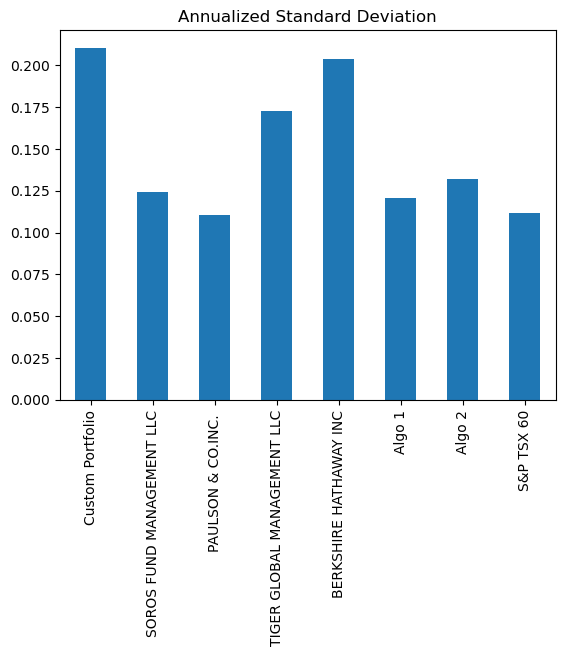

In [62]:
# Calculate the Annualized Standard Deviation
all_annual_std = all_returns.std() * np.sqrt(252)
all_annual_std.plot.bar(title="Annualized Standard Deviation")

<AxesSubplot:title={'center':'Rolling 21-Day Standard Deviation'}, xlabel='Date'>

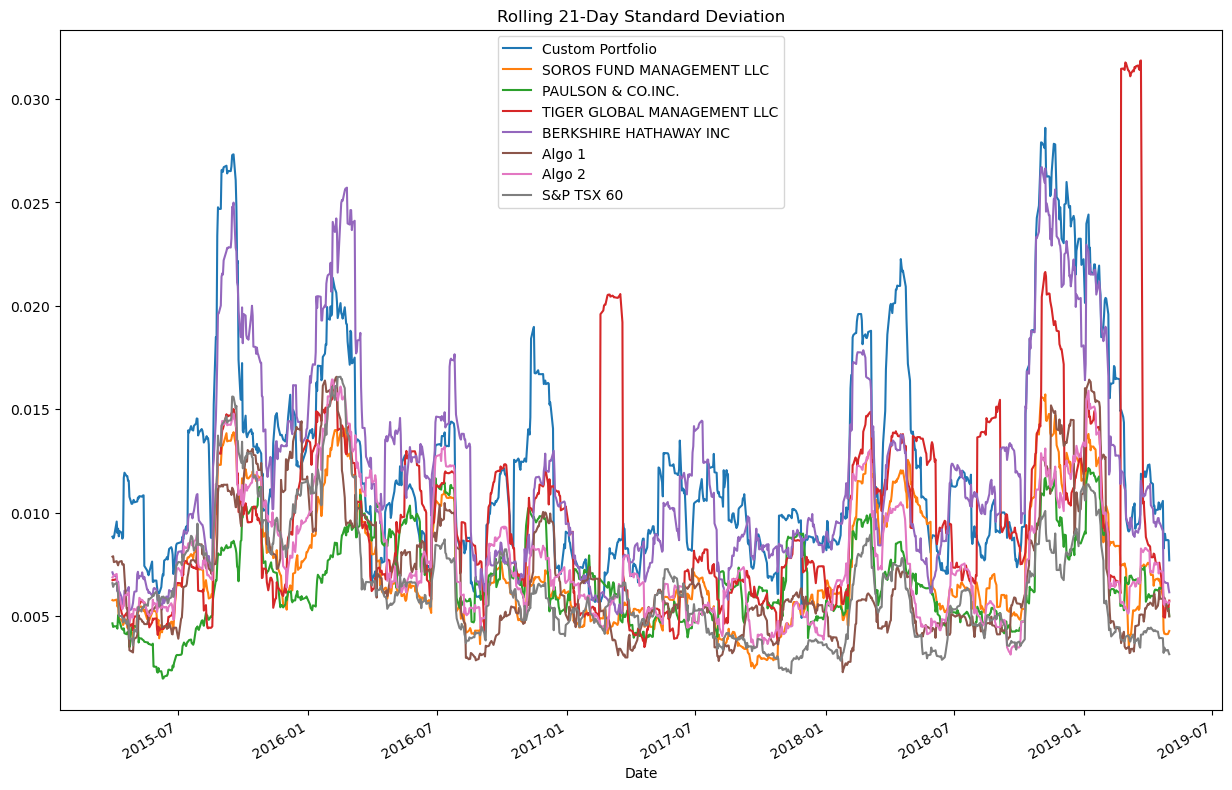

In [66]:
# Calculate rolling std with a 21-day window
all_rolling_std = all_returns.rolling(window=21).std()
all_rolling_std.plot(figsize=(15,10),title="Rolling 21-Day Standard Deviation")

<AxesSubplot:>

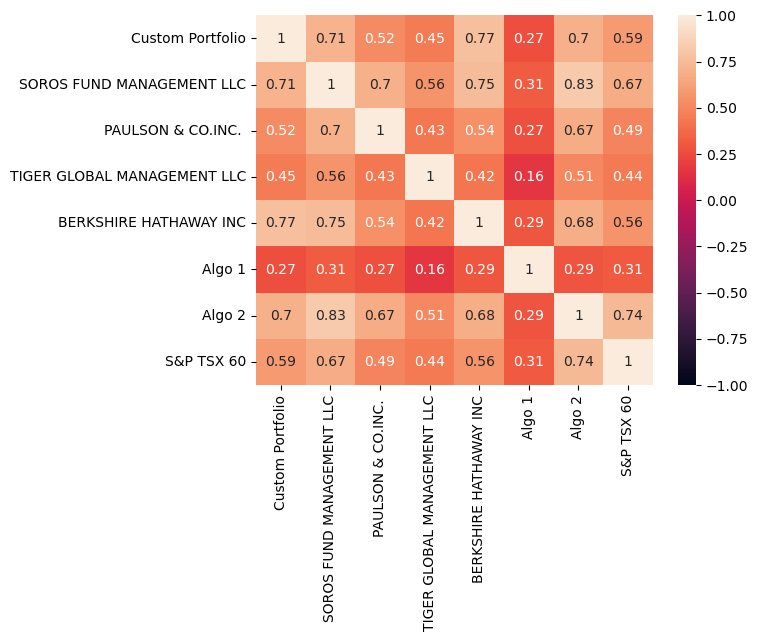

In [67]:
# Calculate the correlation of all portfolios
all_corr = all_returns.corr()
sns.heatmap(all_corr, vmin=-1, vmax=1, annot=True)

#### Custom Portfolio Beta Analysis

<AxesSubplot:title={'center':'Custom Portfolio Beta Analysis'}, xlabel='Date'>

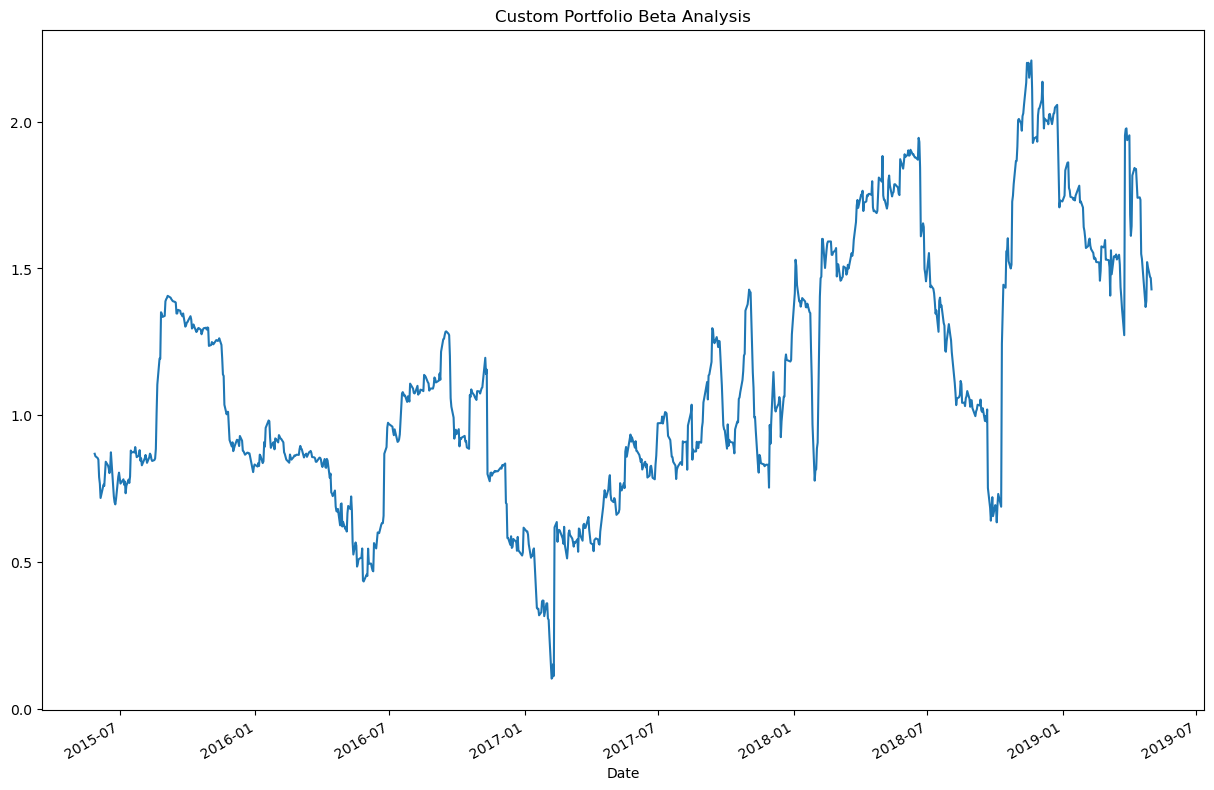

In [70]:
# Calculate the 60-day rolling beta of the custom portfolio compared to the Index
cust_rolling_cov = all_returns["Custom Portfolio"].rolling(window=60).cov(all_returns["S&P TSX 60"])

cust_rolling_variance = all_returns["S&P TSX 60"].rolling(window=60).var()

cust_beta = cust_rolling_cov/cust_rolling_variance

cust_beta.plot(figsize=(15,10), title="Custom Portfolio Beta Analysis")

#### Custom Portfolio Sharpe Ratio Analysis

<AxesSubplot:title={'center':'Sharpe Ratio'}>

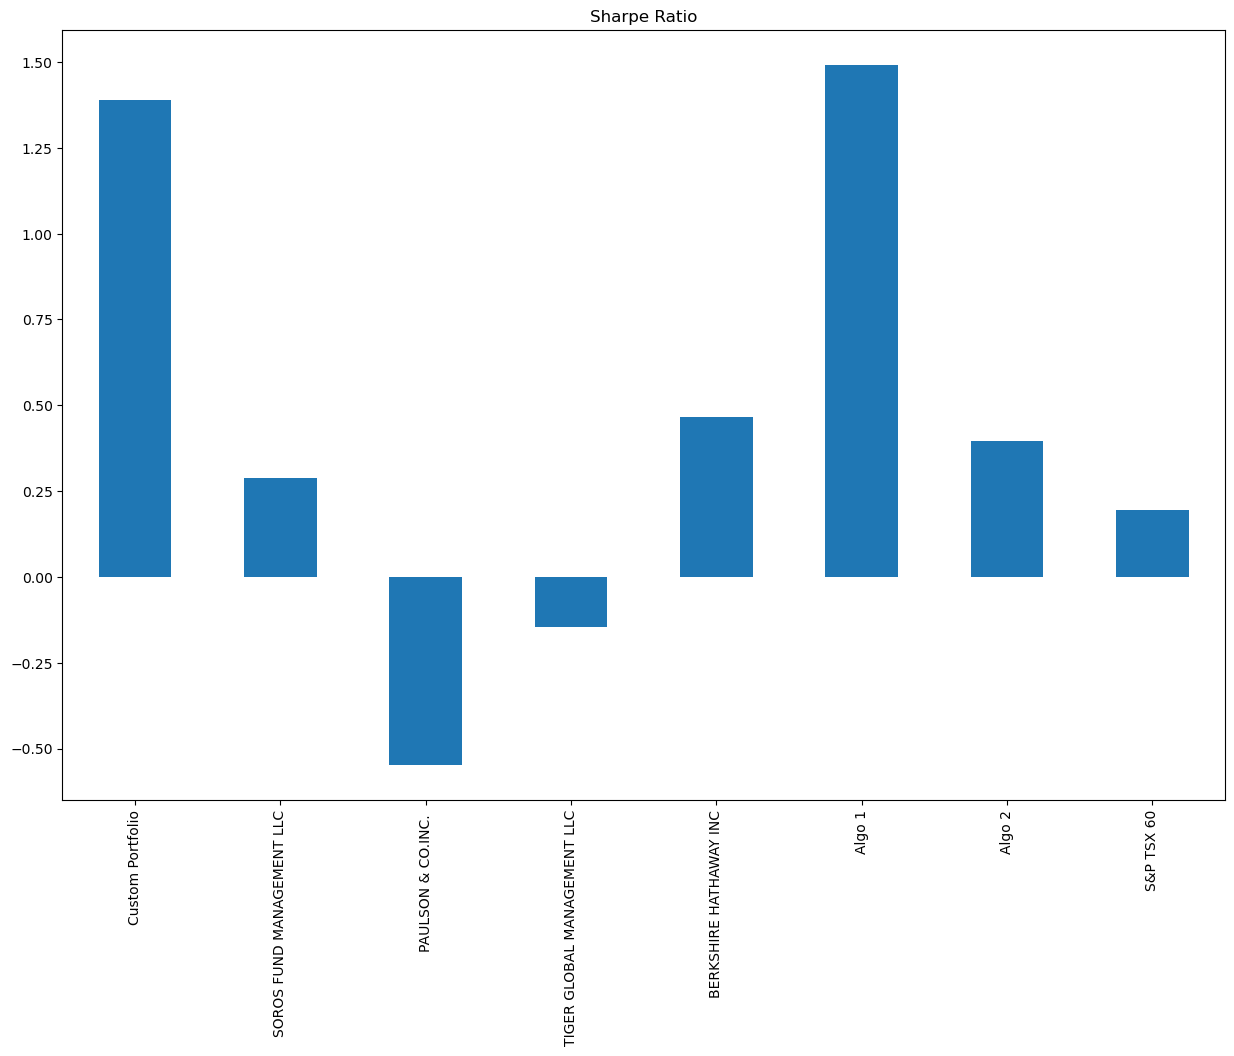

In [105]:
cust_sharpe = (all_returns.mean() * 252) / (all_returns.std() * np.sqrt(252))
cust_sharpe.plot.bar(figsize=(15,10), title="Sharpe Ratio")

#### Custom Portfolio Cumulative Return and Profit

<AxesSubplot:title={'center':'Custom Portfolio Cumulative Returns'}, xlabel='Date'>

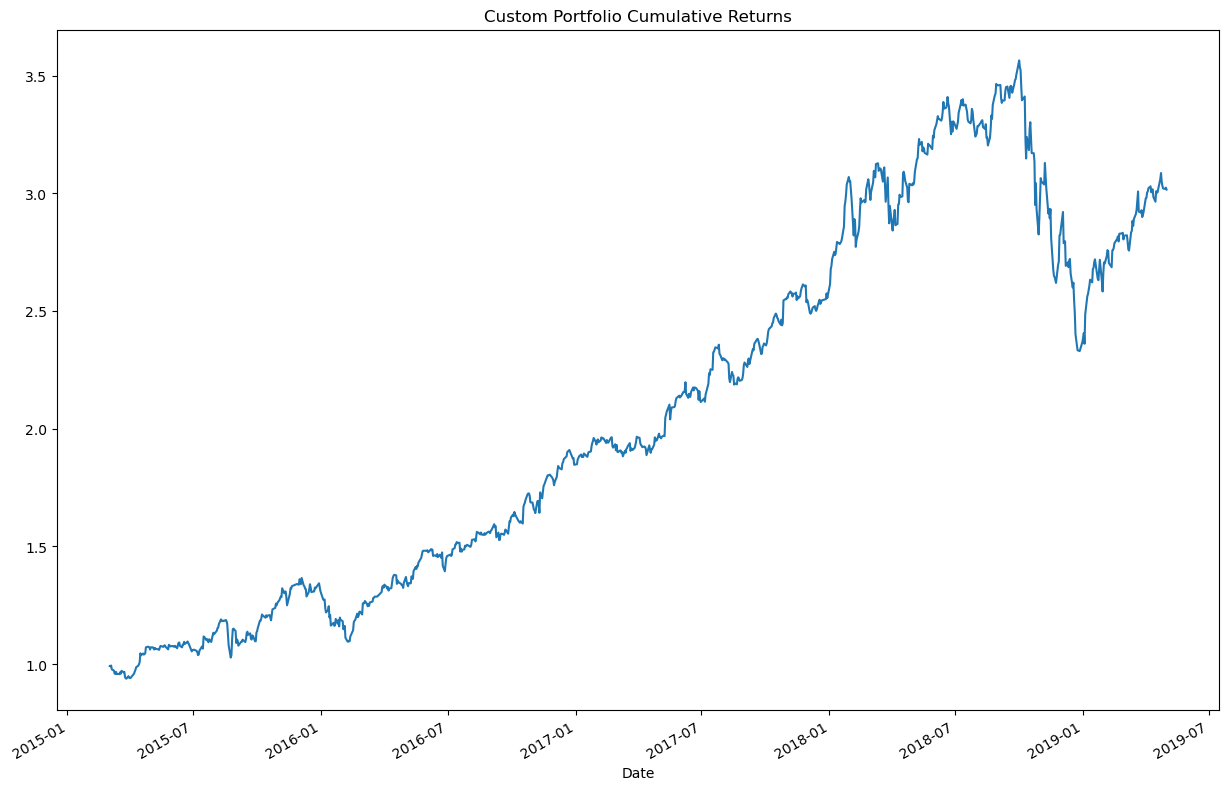

In [79]:
cust_cumulative_return = (1 + all_returns["Custom Portfolio"]).cumprod()
cust_cumulative_return.plot(figsize=(15,10), title="Custom Portfolio Cumulative Returns")

<AxesSubplot:title={'center':'Custom Portfolio Cumulative Profit'}, xlabel='Date'>

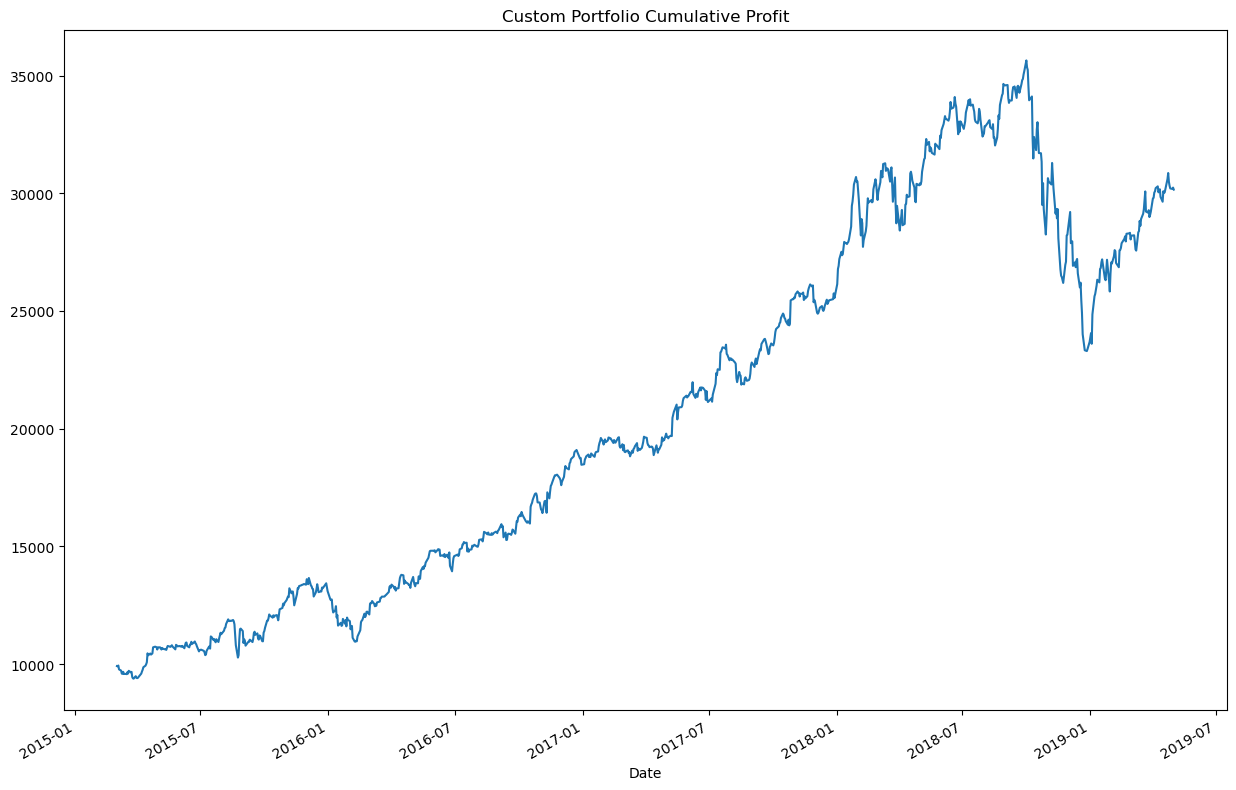

In [92]:
# Show the result of a $10,000 investment into our custom portfolio
investment = 10000

cust_cumulative_profit = investment * cust_cumulative_return

cust_cumulative_profit.plot(figsize=(15,10), title="Custom Portfolio Cumulative Profit")

Plot the cumulative return of the custom portfolio with the top 3 performing portfolios and the index

In [98]:
# Take the cumulative returns of the top 3 performing portfolios and the index
algo1_returns = cumulative_returns["Algo 1"]
algo2_returns = cumulative_returns["Algo 2"]
berkshire_returns = cumulative_returns["BERKSHIRE HATHAWAY INC"]
index_returns = cumulative_returns["S&P TSX 60"]

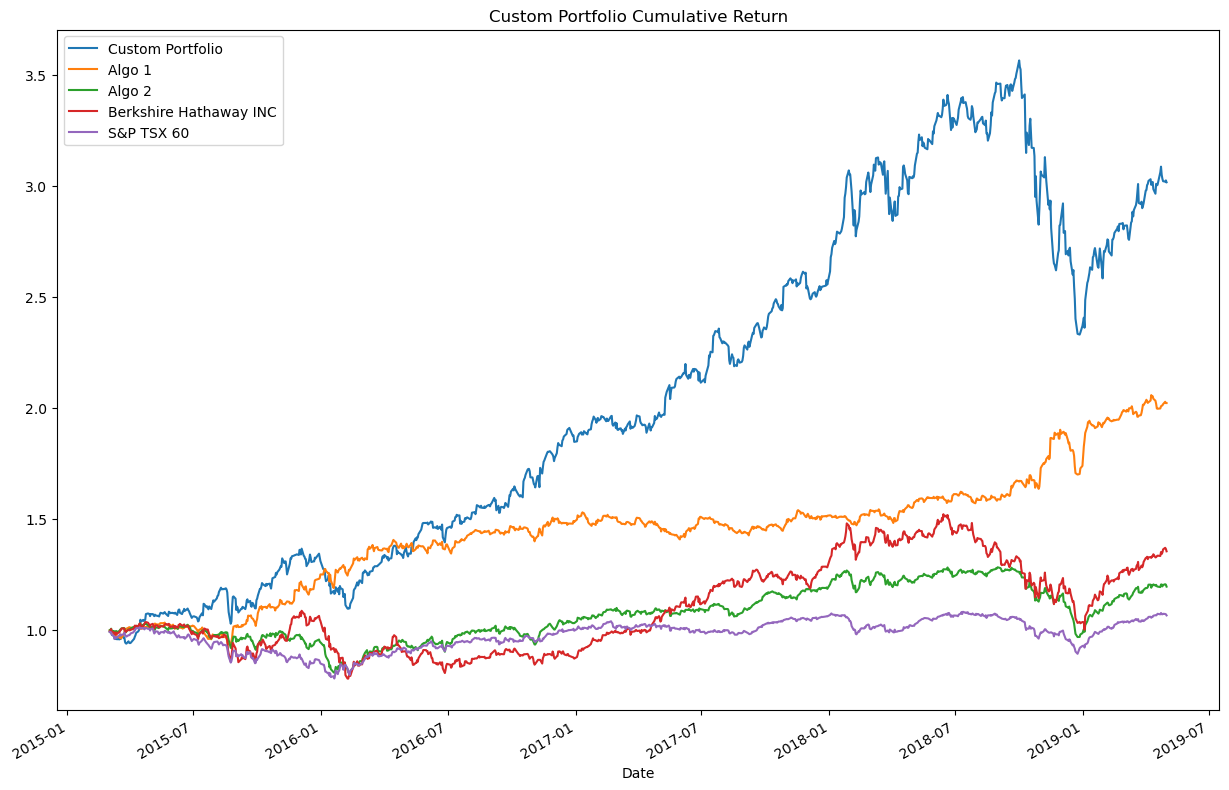

In [103]:
# Overlay the returns to compare our custom portfolio with the top performings
ax = cust_cumulative_return.plot(figsize=(15,10), title="Custom Portfolio Cumulative Return")

algo1_returns.plot(ax=ax)
algo2_returns.plot(ax=ax)
berkshire_returns.plot(ax=ax)
index_returns.plot(ax=ax)

ax.legend(
    [
        "Custom Portfolio",
        "Algo 1", 
        "Algo 2", 
        "Berkshire Hathaway INC", 
        "S&P TSX 60"
    ]
)

Our Custom Portfolio performs extremely well compared to the other top performing portfolios in the list. It is the least correlated with the Top performing portfolio, in our Algo 1. 
Our Custom Portfolio has the highest Annualized Standard Deviation, showing us that it is the more riskier investment. However, our analysis shows that it has the highest Risk-to-Return, only coming second to our Algo 1 Portfolio. So that extra risk, may be worth the investment into our Custom Portfolio.